In [94]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Once data has finished processing, load data from folder structure
# text-data/
# ├─ advertisement/
# ├─ email/
# ├─ invoice/
# ....
data = load_files('../text-data', encoding='utf-8', decode_error='ignore')

X = data.data               
y = data.target             
class_names = data.target_names 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Tokenize
max_words = 20000
tokenizer = Tokenizer(
    num_words=max_words,
    filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True
)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# One-hot encode labels
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [96]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, embeddings_regularizer=l2(0.001)))
model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.build(input_shape=(None, max_len))
model.summary()

# Train
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print("Test accuracy:", acc)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,660,880 (10.15 MB)

 Trainable params: 2,660,880 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.1856 - loss: 2.8316 - val_accuracy: 0.3275 - val_loss: 2.2357
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.4025 - loss: 2.0141 - val_accuracy: 0.4975 - val_loss: 1.7133
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.5406 - loss: 1.6431 - val_accuracy: 0.5625 - val_loss: 1.5911
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.6192 - loss: 1.4738 - val_accuracy: 0.6175 - val_loss: 1.5132
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.6936 - loss: 1.2833 - val_accuracy: 0.6725 - val_loss: 1.3870
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.7567 - loss: 1.1120 - val_accuracy: 0.6750 - val_loss: 1.3734
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.7992 - loss: 1.0302 - val_accuracy: 0.6950 - val_loss: 1.3888
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.8025 - loss: 1

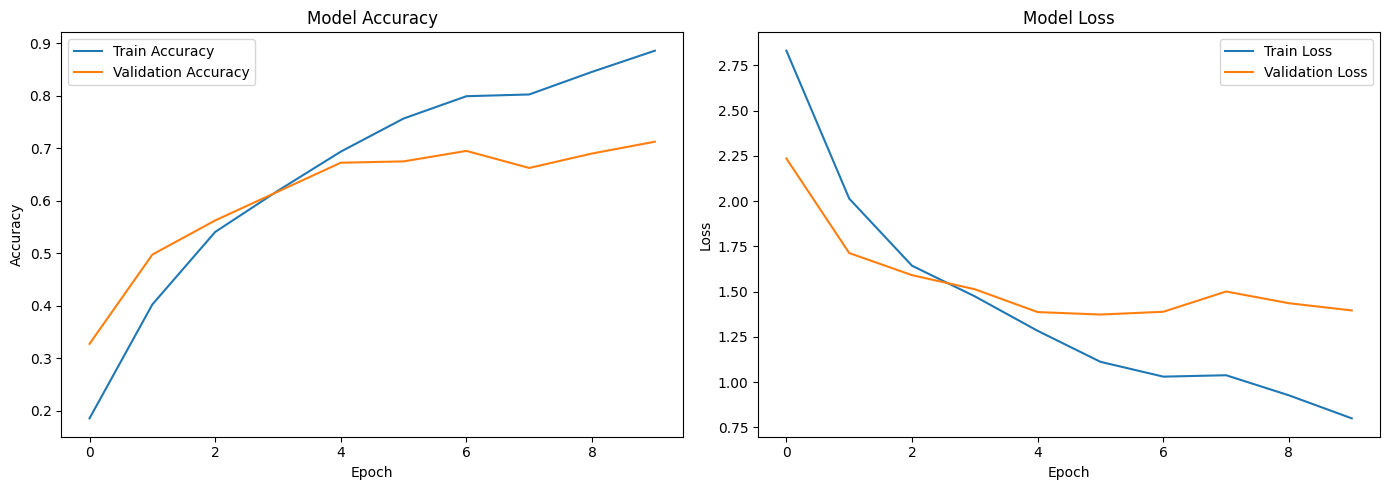

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch') 
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


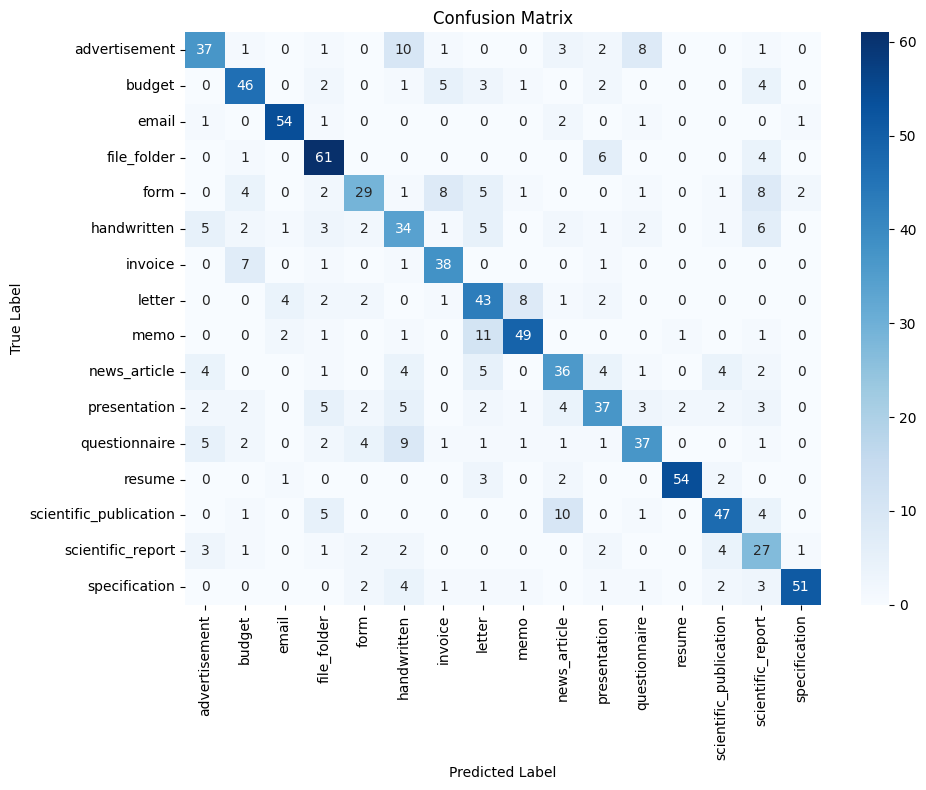

In [98]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [99]:
# analyzing misclassifications
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

misclassified_indices = np.where(y_test != y_pred_classes)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")

# get true label and the model's prediction
misclassified_pairs = {}
for i in misclassified_indices:
    true_label = class_names[y_test[i]]
    predicted_label = class_names[y_pred_classes[i]]
    pair = (true_label, predicted_label)
    misclassified_pairs[pair] = misclassified_pairs.get(pair, 0) + 1

sorted_pairs = sorted(misclassified_pairs.items(), key=lambda x: x[1], reverse=True)
print("10 most common misclassifications:")
for pair, count in sorted_pairs[:10]:
    print(f"True: {true_label}, Predicted: {predicted_label}, Count: {count}")

Classification Report:
                         precision    recall  f1-score   support

         advertisement       0.65      0.58      0.61        64
                budget       0.69      0.72      0.70        64
                 email       0.87      0.90      0.89        60
           file_folder       0.69      0.85      0.76        72
                  form       0.67      0.47      0.55        62
           handwritten       0.47      0.52      0.50        65
               invoice       0.68      0.79      0.73        48
                letter       0.54      0.68      0.61        63
                  memo       0.79      0.74      0.77        66
          news_article       0.59      0.59      0.59        61
          presentation       0.63      0.53      0.57        70
         questionnaire       0.67      0.57      0.62        65
                resume       0.95      0.87      0.91        62
scientific_publication       0.75      0.69      0.72        68
     scientific

In [100]:
model.save('rnn_classifier.keras')